# Staralt

This project is just a copy of staralt but personalised for my own use. 
<br>

Staralt takes the **location**, **date** and **target coordinates** and returns a plot of the altitude as a function of time from a little before and after sunset/rise. It also plots the lunar path,  with angular separation plotted across the graph.
<br>

##### Takes
<ul>
    <li>location</li>
    <li>date</li>
    <li>target coordinates</li>
</ul>

##### Returns
<ul>
    <li>transit time and altitude</li>
    <li>sunrise & sunset</li>
    <li>star altitude between the sunset/rise</li>
    <li>moon altitude</li>
    <li>moon separation</li>
</ul>

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt

# from nose import tools as nt

from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.visualization import time_support, quantity_support
quantity_support()
time_support()
from astropy.coordinates import SkyCoord, EarthLocation, get_body

In [2]:
# location, time and coordinates
deg = u.degree
m = u.meter
location = EarthLocation(lat=53*deg, lon=1.5*deg, height=131*m)
time = Time('2023-1-28', location=location)
target = SkyCoord(ra='20h00m00s', dec='+70d00m00s', frame='icrs')
sun = get_body('sun', time)
moon = get_body('moon', time)
type(location)

astropy.coordinates.earth.EarthLocation

### Position

#### Altitude and Azimuth
It is useful to convert RA-DEC to ALT-AZ for a given LAT. This can be done with just DEC and LAT:

$$\sin(\mbox{ALT}) = \sin(\mbox{LAT})\sin(\mbox{DEC}) + \cos(\mbox{LAT})\cos(\mbox{DEC})\cos(\mbox{HA})$$

$$\cos(\mbox{AZ}) = \frac{\sin(\mbox{DEC}) - \sin(\mbox{LAT})\sin(\mbox{ALT})}{\cos(\mbox{LAT})\cos(\mbox{ALT})}.$$

#### Transit
##### Altitude
These coordinates depend on time as the target moves across the celestial sphere. This time is represented by the hour angle, HA. The target transits at $HA = 0$, so it is easy to find the transit altitude $a_t$.

$$a_t = (90^\circ - \mbox{LAT}) + \mbox{DEC}$$

##### Time
The transit time is dependent on the RA of the target (RA$_\star$) and the Sun (RA$_\odot$).
<ol>
    <li>Find RA$_\odot$ on the observing date</li>
    <li>Find the middle of the night (t$_{mid} = \mbox{LONGITUDE}/15$ gives hours past midnight in UTC)</li>
    <li>Find the optimal transit time (target directly opposite the Sun) with RA$_\odot^{opt}$ RA$_\star$ + 12h</li>
    <li>Find the difference between the Sun's RA on the observing and optimal date, $\Delta\mbox{RA}_\odot$</li>
    <li>Add the time from midnight $t_{transit} = t_{mid} + \Delta\mbox{RA}_\odot$</li>
    <li>The calculated HA can be used to plot the stars whole path across the sky.</li>
</ol>

In [3]:
def transits(location, target, time):
    """
    determine the transit time, altitude and middle of the night of a target given a location
    """
    # transit altitude
    transitAltitude = (90*deg - location.lat) + target.dec
    # RA of the Sun on the observing date
    raSun = get_body('sun', time).ra.hour *u.hour
    # middle of the nigth (UTC)
    timeMidnight = -location.lon.hour * u.hour + time
    # optimal RA of the Sun
    def optRAsun(target):
        raSunOptimal = target.ra.hour*u.hour + 12*u.hour
        if raSunOptimal > 24*u.hour:
            raSunOptimal = raSunOptimal - 24*u.hour
        return raSunOptimal
    raSunOptimal = optRAsun(target)
    # difference between optimal and observing date RA_sun
    dRA = raSunOptimal - raSun
    # find the transit time
    transitTime = timeMidnight + dRA
    return transitAltitude.deg, transitTime, timeMidnight

In [4]:
# test the transits function for Mars at the Roque on 29/01/2025
roque = EarthLocation.of_site('Roque de los Muchachos')
mars = SkyCoord(ra='07h33m48s', dec='+26d01m20s', frame='icrs')
time = Time('2025-01-29')
a, t, m = transits(roque, mars, time)

# def test_transits():
#     nt.assert_almost_equal(a, 87, places=0, msg="Transit altitude is wrong")
    
# test_transits()

### Sunrise and Sunset
<br>

We simply need to calculate the HA when the ALT of the Sun is -0.5 (as the disc of the Sun is 0.5 degrees). So the equation is as follows:

$$\cos{\left( \mbox{HA} \right)} = \frac{ \sin{\left( -0.5^\circ\right)} -\sin{\left( \mbox{LAT} \right)} \sin{\left( \mbox{DEC}_\odot \right)} }{ \cos{\left( \mbox{LAT} \right)} \cos{\left( \mbox{DEC}_\odot \right)} }$$

Sunset is by convention 12 (midday) plus the HA calculated here. By symmetry, sunrise will be the same distance from the middle of the night as the sunset.

In [5]:
def riseset(location, time):
    # get sun
    sun = get_body('sun', time)
    # find hour angle of sunset
    numerator = np.sin(-0.5 *np.pi/180) - np.sin(location.lat.rad) * np.sin(sun.dec.rad)
    denominator = np.cos(location.lat.rad) * np.cos(sun.dec.rad)
    haSun = np.arccos(numerator/denominator) *180/(15*np.pi)
    # find sunset
    sunset = 12*u.hour + haSun*u.hour + time - 1*u.day
    # difference between sunset and middle of night
    midnight = -location.lon.hour * u.hour + time
    time2midnight = abs(sunset - midnight).value * 24 * u.hour
    # sunrise
    sunrise = midnight + time2midnight
    return sunset, sunrise

In [6]:
# test riseset function
birmingham = EarthLocation(lat=52*u.deg, lon=-1.8*u.deg, height=140*u.m)
time = Time('2025-01-29', scale='utc', location=birmingham)

alt, tim, midn = transits(birmingham, mars, time) # find trans altitude & time and midnight
ss, sr = riseset(birmingham, time) # find sunrise and sunset for bham on 29th Jan 2025
print(ss, sr) # these are pretty good!

2025-01-28 16:25:21.679 2025-01-29 07:49:02.321


##### Twilight

There are levels of darkness, depending on the altitude of the Sun. These can be calculated the same way sunrise and sunset are found. 

In [7]:
# calculate the twilight times
def twilight(location, time, angle):
    """
    calculate the times of twilight for a given night & location and angle
    """
    # sun
    sun = get_body('sun', time)
    # find hour angle of twilight
    numerator = np.sin(-angle *np.pi/180) - np.sin(location.lat.rad) * np.sin(sun.dec.rad)
    denominator = np.cos(location.lat.rad) * np.cos(sun.dec.rad)
    haSun = np.arccos(numerator/denominator) *180/(15*np.pi)
    # find end of twilight
    twilight_e = 12*u.hour + haSun*u.hour + time - 1*u.day
    # difference between twilight and middle of night
    midnight = -location.lon.hour * u.hour + time
    time2midnight = abs(twilight_e - midnight).value * 24 * u.hour
    # start of twilight
    twilight_s = midnight + time2midnight
    return twilight_s, twilight_e

def twilight_zones(location, time):
    """
    calculate the start and end times for civil, nauticle and astronomical twillight
    """
    # civil twilight
    civil = twilight(location, time, 6) # sun 6 degrees below horizon
    # nauticle twilight
    nauticle = twilight(location, time, 12) # sun 12 degrees below horizon
    # civil twilight
    astronomical = twilight(location, time, 18) # sun 18 degrees below horizon
    return civil, nauticle, astronomical

##### Altitude

The altitude can be calculated with the first equation above:

$$\sin(\mbox{ALT}) = \sin(\mbox{LAT})\sin(\mbox{DEC}) + \cos(\mbox{LAT})\cos(\mbox{DEC})\cos(\mbox{HA})$$

where the HA can be calculated with:

$$\mbox{HA} = \mbox{LST} - \mbox{RA}$$

In [8]:
# calculate hour angle
def find_ha(location, time, target, unit='degree'):
    """
    calculate the hour angle of a given target for some location and time
    """
    # find LST
    LST = time.sidereal_time('apparent')
    # calculate HA
    HA = LST.deg - target.ra.deg
    
    if unit == 'hour':
        HA = (HA / 15) *u.hour # return HA in hours
    else:
        HA = HA *u.deg # return HA in degrees (default)
    return HA

find_ha(birmingham, time, mars, unit='hour')

<Quantity 0.88321843 h>

In [9]:
# calculate altitude
def find_alt(location, target, ha):
    """ find the altitude of an objects for a given location and altitude """
    lat = location.lat.rad # latitude in radians
    dec = target.dec.rad # declination in radians
    if type(ha) != list:
        sinalt = np.sin(lat)*np.sin(dec) + np.cos(lat)*np.cos(dec)*np.cos(ha.to('radian'))
        alt = np.arcsin(sinalt)
        alts = alt.to(deg)
    else:
        alts = []
        for h in ha:
            sinalt = np.sin(lat)*np.sin(dec) + np.cos(lat)*np.cos(dec)*np.cos(h.to('radian'))
            alt = np.arcsin(sinalt)
            alts.append(alt.to(deg))
    return alts

find_alt(birmingham, mars, find_ha(birmingham, time, mars, unit='degrees'))

<Quantity 62.15813267 deg>

In [10]:
# calculate azimuth
def find_az(location, target, altitude):
    """ calculate the azimuth of a target at a given time given the altitude (and therefore time) from spherical trig """
    lat = location.lat.rad # latitude in radians
    dec = target.dec.rad # declination in radians
    alt = altitude # altitude in degrees
    # from spherical trig
    num = np.sin(dec) - np.sin(lat)*np.sin(alt.to('radian'))
    den = np.cos(lat)*np.cos(alt.to('radian'))
    cosaz = num / den
    az = np.arccos(cosaz)
    if type(az) == float:
        az = az * u.radian
    return az.to(deg)
        

example_alt = find_alt(birmingham, mars, find_ha(birmingham, time, mars, unit='degrees')) # the one calculated above
find_az(birmingham, mars, example_alt)

<Quantity 153.83542222 deg>

#### Describing the night

We want the target's position for an entire night. This could be found by taking the sunrise and sunset times, starting an hour before and after these times. 

In [11]:
# define a random date and return an array covering the whole night
obsDate = Time('2025-02-05') # random observing date
srise, sset = riseset(birmingham, obsDate) # sunrise and sunset
night = np.linspace(srise - 1*u.hour, sset + 1*u.hour, 24*60)

def find_night(location, obs_date):
    """
    create an array of times for a given date to define the night (+/- hours before/after midnight)
    """
    # find sunrise and sunset
    srise, sset = riseset(location, obs_date)
    # return an array of times per minute
    return np.linspace(srise - 1*u.hour, sset + 1*u.hour, 24*60)

In [12]:
# test
n = find_night(birmingham, obsDate)
n[0].to_string().split()[0]

'2025-02-04'

#### Night Summary

Now for a given night, location and target we can find:
<ul>
    <li>Sunrise & sunset</li>
    <li>Civil, nauticle, astronomical twilight</li>
    <li>Midnight</li>
    <li>Altitude of target for a give time</li>
    <li>Transit time and altitude</li>
</ul>

Next steps are to combine these functions to output all these results in one go.

In [13]:
def whatsGoingOnTonight(location, obs_date, target):
    """
    determine a target's altitude, transit times across a night
    """
    # night
    night = find_night(location, obs_date) # define the observing night
    sset, srise = riseset(location, obs_date) # define the sunrise and sunset for the goven night
    civil, nauticle, astronomical = twilight_zones(location, obs_date) # define civil, nauticle, astronomical twilight
    
    # target
    altitudes = [] # array of altitudes as a function of time
    for minute in night:
        ha = find_ha(location, minute, target, unit='degree')
        alt = find_alt(location, target, ha)
        altitudes.append(alt.value)
    transAlt, transTime, mid = transits(location, target, obs_date) # transit altitude and time
    azimuths = []
    for alt in altitudes:
        alt = alt * u.deg
        azimuths.append(find_az(location, target, alt).value)
    
    return night, altitudes, azimuths, [sset, srise], [civil, nauticle, astronomical], [transAlt, transTime], mid

In [14]:
ORM = EarthLocation.of_site('Roque de los Muchachos') # location: roque
observing_date = Time('2025-02-05', location=ORM) # observing date 05/02/2025
betelgeuse = SkyCoord(ra='05h55m10.30536s', dec='+07d24m25.4304s', frame='icrs') # target: betelgeuse

night, altitudes, azimuths, sunriseset, twlt, trans, midnight = whatsGoingOnTonight(birmingham, Time('2025-01-29', scale='utc', location=birmingham), mars)

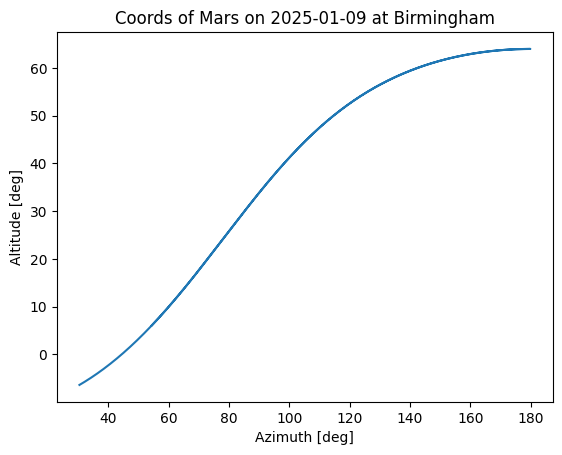

In [15]:
plt.plot(azimuths, altitudes)
plt.xlabel('Azimuth [deg]'), plt.ylabel('Altitude [deg]'), plt.title(f'Coords of Mars on 2025-01-09 at Birmingham')
plt.show()

#### Make a pretty picture!

In [16]:
def hourText(time):
    """
    take the Time() object and return just hh:mm UTC
    """
    t = str(time).split()
    hr = t[1].split(":")[0] + ':' + t[1].split(":")[1] + ' UTC'
    return hr

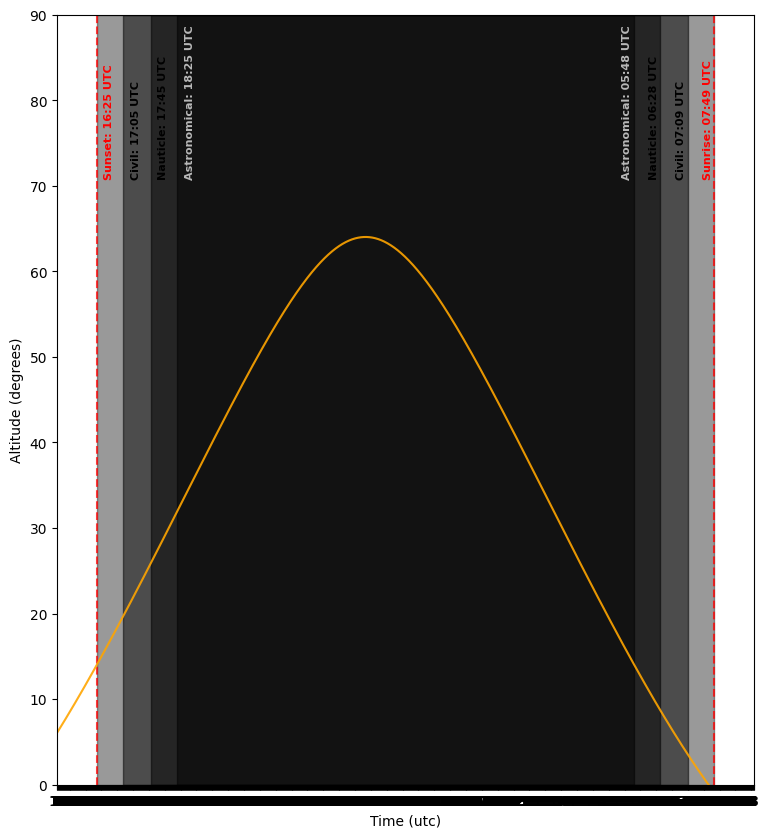

Transit time: 22:55 UTC
Transit altitude 64.0


In [17]:
# make the plot
fig, ax = plt.subplots(figsize=[9,10])

# axes
ax.plot(night.mjd, [0]*len(night), alpha=0)

# sunrise and sunset
# sunrise
ax.vlines(sunriseset[0], 0, 90, color='red', linestyle='dashed', alpha=0.75) # line showing sunset
ax.annotate(f'Sunset: {hourText(sunriseset[0])}', (sunriseset[0]+0.0075, 71), color='red', rotation=90, fontsize=8, fontweight='bold')
# sunset
ax.vlines(sunriseset[1], 0, 90, color='red', linestyle='dashed', alpha=0.75) # line showing sunrise
ax.annotate(f'Sunrise: {hourText(sunriseset[1])}', (sunriseset[1]-0.012, 71), color='red', rotation=90, fontsize=8, fontweight='bold')
# fill
ax.fill_between(np.linspace(sunriseset[0], sunriseset[1]), 0, 90, color='k', alpha=0.4) # darken

# twilight
# civil
ax.fill_between(np.linspace(twlt[0][0], twlt[0][1]), 0, 90, color='k', alpha=0.5)
ax.annotate(f'Civil: {hourText(twlt[0][0])}', (twlt[0][0]-0.012, 71), color='k', rotation=90, fontsize=8, fontweight='bold')
ax.annotate(f'Civil: {hourText(twlt[0][1])}', (twlt[0][1]+0.0075, 71), color='k', rotation=90, fontsize=8, fontweight='bold')
# nauticle
ax.fill_between(np.linspace(twlt[1][0], twlt[1][1]), 0, 90, color='k', alpha=0.5)
ax.annotate(f'Nauticle: {hourText(twlt[1][0])}', (twlt[1][0]-0.012, 71), color='k', rotation=90, fontsize=8, fontweight='bold')
ax.annotate(f'Nauticle: {hourText(twlt[1][1])}', (twlt[1][1]+0.0075, 71), color='k', rotation=90, fontsize=8, fontweight='bold')
# astronomical
ax.fill_between(np.linspace(twlt[2][0], twlt[2][1]), 0, 90, color='k', alpha=0.5)
ax.annotate(f'Astronomical: {hourText(twlt[2][0])}', (twlt[2][0]-0.012, 71), color='white', alpha=0.7, rotation=90, fontsize=8, fontweight='bold')
ax.annotate(f'Astronomical: {hourText(twlt[2][1])}', (twlt[2][1]+0.0075, 71), color='white', alpha=0.7, rotation=90, fontsize=8, fontweight='bold')

# altitude plot
ax.plot(night, altitudes, color='orange', alpha=0.9)

# limits
labels = []
for n in night:
    labels.append(n.datetime.hour)
# ax.set_xticklabels(labels)
ax.set_xticks(night, labels)
ax.set_ylim(0, 90), ax.set_ylabel('Altitude (degrees)')
ax.set_xlim(night[0], night[-1])
plt.show()

print(f"Transit time: {hourText(trans[1])}")
print(f"Transit altitude {trans[0]:.1f}")

Things to do:
<ul>
    <li>Get the x axis right</li>
    <li>Create a circle representing a sky map and plot the star's position across the sky</li>
</ul>

#### Moon distance

For each target (and of course the Moon) we have the altitude and azimuth for a given time (or night) from the _whatsGoingOnTonight()_ function. So, we have the coordinates in the sky of the target and Moon, and we thereore can get the angle between them!

###### Method
Imagine two points on the celestial sphere (above the observer's horizon) which have some coordinates $A(alt_A, az_A)$ and $B(alt_B, az_B)$. 

Together with the observer's zenith, a spherical triangle can be made with points A, B, and Z.

So to find the angular separation AB, we can use the cosine rule again: $$\cos{(AB)} = \cos{(ZA)}\cos{(ZB)} - \sin{(ZA)}\sin{(ZB)}\cos{(AZB)}$$

> AZB is the angle between the points A and B from the zenith Z given by $\gamma = |az_A - az_B|$ (-180$^\circ$ if $\gamma > 180^\circ$).
>
> The distances ZA and ZB are just the zenith distances given by $z_A = 90-alt_A$ and $z_B = 90-alt_B$.

So, we can re-write our equation as: $$\cos{(AB)} = \cos{z_A}\cos{z_B} - \sin{z_A}\sin{z_B}\cos{\gamma}$$

where $AB$ is the angular separation between the two objects (or a target and the Moon!).

In [18]:
# calculate Moon distance
def find_moondist(target1, target2, ang='degrees'):
    """ calculate the angular separation between two objects in the night sky (or the daytime sky, I won't judge) 

    params
    ------
    target1, 2 (list [float, float]) : altaz coordinates of targets in the format [alt, az], in degrees preferably (if not change ang to 'silly bastard')

    output
    ------
    separation (float) : angular separation of the two targets in degrees
    """
    # params
    alt1, az1 = target1 # in degrees remember!
    alt2, az2 = target2
    # convert to equation form
    z1 = 90 - alt1
    z2 = 90 - alt2
    gamma = np.abs(az1 - az2)
    if gamma > 180: # don't go round the whole circle like a dummy!
        gamma -= 180
    # convert to radians for calculations
    z1 *= np.pi/180
    z2 *= np.pi/180
    gamma *= np.pi/180
    # cosine rule
    cosAB = np.cos(z1)*np.cos(z2) - np.sin(z1)*np.sin(z2)*np.cos(gamma)
    AB = np.arccos(cosAB)
    # back to degrees
    separation = AB * 180/np.pi
    return separation

In [19]:
night_m, altitudes_m, azimuths_m, sunriseset_m, twlt_m, trans_m, midnight_m = whatsGoingOnTonight(birmingham, Time('2025-01-29', scale='utc', location=birmingham), mars)
night_b, altitudes_b, azimuths_b, sunriseset_b, twlt_b, trans_b, midnight_b = whatsGoingOnTonight(birmingham, Time('2025-01-29', scale='utc', location=birmingham), betelgeuse)

In [20]:
index = 200
t_mars = [altitudes_m[index], azimuths_m[index]]
t_betelgeuse = [altitudes_b[index], azimuths_b[index]]
find_moondist(t_mars, t_betelgeuse)

# sep = []
# for i in range(len(altitudes_m)):
#     t_mars = [altitudes_m[i], azimuths_m[i]]
#     t_betelgeuse = [altitudes_b[i], azimuths_b[i]]
#     sep.append(find_moondist(t_mars, t_betelgeuse))

np.float64(117.39426069812119)

## Final function

In [27]:
# turn it into a function
def plotAlt(location, obsDate, targets, fs=[20,10], starname=['Star']):
    """
    take a location, observing date and target(s) and plot altitude over the night
    """
    # calculate all stuff for moon
    night_moon, altitudes_moon, azimuths_moon, sunriseset_moon, twlt_moon, trans_moon, midnight_moon = whatsGoingOnTonight(location, obsDate, moon)
    
    # calculate all stuff for target
    target_list = []
    separations = [] # separation from moon
    for target in targets:
        night, altitudes, azimuths, sunriseset, twlt, trans, midnight = whatsGoingOnTonight(location, obsDate, target)
        target_list.append([night, altitudes])
        # separation from moon
        seps_target = []
        for i in range(len(altitudes)):
            mn = [altitudes_moon[i], azimuths_moon[i]]
            targ = [altitudes[i], azimuths[i]]
            seps_target.append(find_moondist(mn, targ))
        separations.append(seps_target)
            
    night, altitudes, azimuths, sunriseset, twlt, trans, midnight = whatsGoingOnTonight(location, obsDate, targets[0])
    # calculate all stuff for moon
    night_moon, altitudes_moon, azimuths_moon, sunriseset_moon, twlt_moon, trans_moon, midnight_moon = whatsGoingOnTonight(location, obsDate, moon)
    
    # create the plot
    fig, ax = plt.subplots(figsize=fs)
    
    # SUNRISE AND SUNSET
    # sunrise
    ax.vlines(sunriseset[0], 0, 90, 
              color='red', linestyle='dashed', alpha=0.75) # line showing sunset
    ax.annotate(f'Sunset: {hourText(sunriseset[0])}', (sunriseset[0]+0.0075, 71), 
                color='red', rotation=90, fontsize=8, fontweight='bold')
    # sunset
    ax.vlines(sunriseset[1], 0, 90, 
              color='red', linestyle='dashed', alpha=0.75) # line showing sunrise
    ax.annotate(f'Sunrise: {hourText(sunriseset[1])}', (sunriseset[1]-0.012, 71), 
                color='red', rotation=90, fontsize=8, fontweight='bold')
    # fill
    ax.fill_between(np.linspace(sunriseset[0], sunriseset[1]), 0, 90, 
                    color='#000510', alpha=0.4) # darken
    
    # TWILIGHT
    # civil
    ax.fill_between(np.linspace(twlt[0][0], twlt[0][1]), 0, 90, color='#000510', alpha=0.5)
    ax.annotate(f'Civil: {hourText(twlt[0][0])}', (twlt[0][0]-0.012, 71), 
                color='k', rotation=90, fontsize=8, fontweight='bold')
    ax.annotate(f'Civil: {hourText(twlt[0][1])}', (twlt[0][1]+0.0075, 71), 
                color='k', rotation=90, fontsize=8, fontweight='bold')
    # nauticle
    ax.fill_between(np.linspace(twlt[1][0], twlt[1][1]), 0, 90, color='#000510', alpha=0.5)
    ax.annotate(f'Nauticle: {hourText(twlt[1][0])}', (twlt[1][0]-0.012, 71), 
                color='#909090', rotation=90, fontsize=8, fontweight='bold')
    ax.annotate(f'Nauticle: {hourText(twlt[1][1])}', (twlt[1][1]+0.0075, 71), 
                color='#909090', rotation=90, fontsize=8, fontweight='bold')
    # astronomical
    ax.fill_between(np.linspace(twlt[2][0], twlt[2][1]), 0, 90, color='#000510', alpha=0.5)
    ax.annotate(f'Astronomical: {hourText(twlt[2][0])}', (twlt[2][0]-0.012, 71), 
                color='white', alpha=0.7, rotation=90, fontsize=8, fontweight='bold')
    ax.annotate(f'Astronomical: {hourText(twlt[2][1])}', (twlt[2][1]+0.0075, 71), 
                color='white', alpha=0.7, rotation=90, fontsize=8, fontweight='bold')


    # ALTITUDE & MOON SEPARATION
    colours = ['#005F73', '#0A9396', '#94D2BD', '#E9D8A6', '#EE9B00', '#CA6702', '#BB3E03', '#AE2012'] # ignore this if you want lol
    # colours = ['#D8F3DC', '#B7E4C7', '#95D5B2', '#74C69D', '#52B788', '#40916C', '#2D6A4F', '#1B4332'] # green palette
    for i in range(len(target_list)):
        times = target_list[i][0]
        alts = target_list[i][1]
        ax.plot(times, alts, alpha=0.75, color=colours[-i], label=starname[i])
        for k in range(15): # annotate the moon separations
            index = int(k/15 * len(times)) # split times into 15 equal points
            ax.annotate(f"{separations[i][index]:.0f}", (times[index], alts[index]), fontsize=10, color=colours[-i])
    ax.plot(night_moon, altitudes_moon, color='grey', linestyle='dashed', alpha=0.75)
    
    
    # LIMITS, LABELS & TITLE
    ax.set_title(f'{night[0].to_string().split()[0]} $|$ lat={location.lat:.2f} long={location.lon:.2f} elev={location.height:.0f}')
    labels = []
    hour = night[0].datetime.hour
    end = night[-1].datetime.hour + 1
    while hour != end:
        if hour > 23:
            hour = hour - 24
        labels.append(hour)
        hour += 1
        if hour == end:
            break

    ax.set_xticks(np.linspace(night[0], night[-1], len(labels)))
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 90), ax.set_ylabel('Altitude (degrees)')
    ax.set_xlim(night[0], night[-1])
    plt.legend()
    fig.savefig('STARALT.pdf', bbox_inches='tight')
    plt.show()

    print(f"Transit time: {hourText(trans[1])}")
    print(f"Transit altitude {trans[0]:.1f}")
    
    return trans

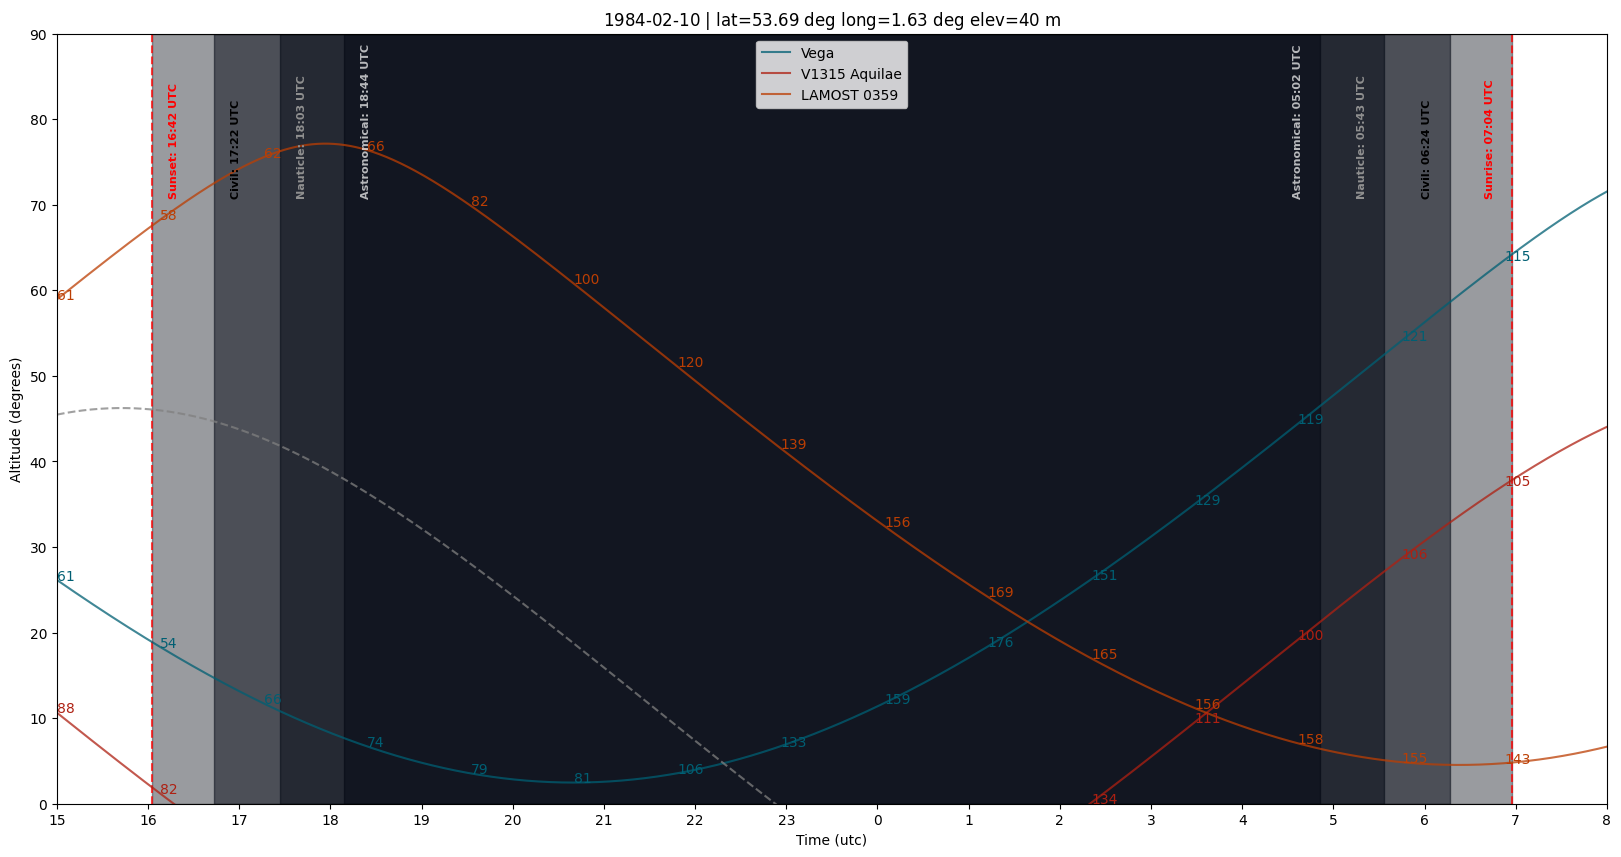

Transit time: 08:54 UTC
Transit altitude 75.1


[np.float64(75.09378894444444),
 <Time object: scale='utc' format='iso' value=1984-02-10 08:54:14.031>]

In [28]:
# test it
dewsbury = EarthLocation(lat=53.6899*u.deg, lon=1.6297*u.deg, height=40*u.meter)
obs_date = Time('1984-02-11', location=dewsbury, scale='utc')
vega = SkyCoord(ra="18h36m56.33635s", dec="+38d47m01.2802s", frame="icrs")
V1315aql = SkyCoord(ra="19h13m54.5308677240s", dec="+12d18m03.239745228s", frame="icrs")
LAMOST0359 = SkyCoord(ra="03h59m13.626515992s", dec="+40d50m35.095271748s", frame="icrs")

plotAlt(dewsbury, obs_date, [vega, V1315aql, LAMOST0359], starname=['Vega', 'V1315 Aquilae', 'LAMOST 0359'])
# plotAlt(dewsbury, obs_date, V1315aql, starname='V1315 Aquilae')
# plotAlt(dewsbury, obs_date, LAMOST0359, starname='LAMOST J035913.61+405035.0')
# plotAlt(dewsbury, obs_date, betelgeuse, starname='Betelgeuse')
# plotAlt(dewsbury, obs_date, mars, starname='Mars')

$\uparrow$ the x-axis is still displaying incorrectly. the actual scale is correct, it is just due to the <TT>xtick</TT> labels where I take the <TT>datetime.hour</TT> and overlay it on the x-axis labels. I would hazard a guess that it is simply taking the first hour of the measurement and displaying this over and over again, instead of the hour corresponding to the actual x-value at a given time of the night.

<span style="color:green;">Update:</span> This has been solved! See the commented out code below for the loop that oslved it.

In [23]:
# labels = []
#     for n in night:
#         labels.append(n.datetime.hour)
# hours = []
# for n in night:
#     hours.append(n.datetime.hour)

# l = []
# start = 1
# end = 10
# while start != end:
#     l.append(start)
#     start += 1

#     if start == end:
#         break
# l

# labels = []
# hour = night[0].datetime.hour
# end = night[-1].datetime.hour + 1
# while hour != end:
#     if hour > 23:
#         hour = hour - 24
#     labels.append(hour)
#     hour += 1
#     if hour == end:
#         break
# print(hour, end)
# print(labels) <-- we got it!

### Sky map

The next stage of this is to create a star map of the target. There are steps to this: 

> the plotAlt function should be able to take multiple targets and plot them on the same graph

> the moon should be plotted and the angular distance to it from the targets plotted

> the sky map should be a circle with $\theta = \mbox{azimuth}$ and $r \propto \mbox{altitude}$.

In [24]:
# plt.style.available